In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 128#1*1024

# gpus = tf.config.list_physical_devices('GPU')
# try:
#     tf.config.set_logical_device_configuration(gpus[0],
#                                               [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
# except RuntimeError as e:        
#     # Memory growth must be set before GPUs have been initialized
#     print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
# from turing.tf_utils import *
# import turing.pinns as tu
# from turing.loss_functions import *


from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from pde_solvers.cn import *

In [2]:
from local_utils import *

# Load parameters

In [20]:
import pandas as pd
df = pd.read_csv("df_network_analysis_full_topology_with_estimates.csv")
df["index"] = range(df.shape[0])

In [64]:
def load_dataset(path, cont=False):
    if cont:
        with open(f"../{path[:-4]}_2", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    else:
        with open(f"../{path}", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

In [5]:
def act(x, K, n):
    """Activatrion"""
    return 1 / (1 + (K / (x + 1e-30)) ** n)


def inh(x, K, n):
    """Inhibition"""
    return 1 / (1 + (x / (K + 1e-30)) ** n)

A_act_AA = lambda A, K_AA: act(A, K_AA, 4)
A_inh_BA = lambda B, K_BA: inh(B, K_BA, 4)
A_prod = lambda A, K_AA, B, K_BA: A_act_BA(A, K_AA)*A_act_BA(B, K_BA)

B_act_AB = lambda A, K_AB: act(A, K_AB, 4)
B_inh_CB = lambda C, K_CB: inh(C, K_CB, 4)
B_prod = lambda A, K_AB, C, K_CB: B_act_AB(A, K_AB)*B_inh_CB(C, K_CB)

C_inh_AC = lambda A, K_AC: inh(A, K_AC, 4)
C_inh_BC = lambda B, K_BC: inh(B, K_BC, 4)
C_act_CC = lambda C, K_CC: act(C, K_CC, 4)
C_prod = lambda A, K_AC, B, K_BC, C, K_CC: C_inh_AC(A, K_AC)*C_inh_BC(B, K_BC)*C_act_CC(C, K_CC)

In [6]:
def to(arr):
    return arr.reshape(128, 128) 

In [7]:
np.set_printoptions(suppress=True)

In [8]:
from scipy.optimize import minimize
def simplex_corners(dim, L):
    """gives the corner of a simplex in a dim-dimensional space
       witk lenght L.
       
       dim: dimensions
       L: simplex lenght
    """
    e = np.eye(dim) * L
    return e

def grid(dim, L, repeat):
    dim_p_1 = dim + 1
    inits = np.zeros((1, dim))
    #bounds = [((0, L * 2),) *dim]
    for i in range(repeat):
        coners = simplex_corners(dim, L * (i+1))
        centers = np.ones((1, dim))*(L * (i+1))/dim
        inits = np.vstack([inits, coners, centers])
        
        #bounds.append([((L * i, L * (i+2)),) *dim] * (dim+1))
        
    return inits#, bounds
        
    
def search_single(dim, L, repeat, func, method='Powell'):
    inits = grid(dim, L, repeat)
    bounds = ((0, L * 2),) *dim
    results = []
    for i, x0 in enumerate(inits):  
        results.append(minimize(func, x0=x0, method=method, bounds=bounds))
        if i % (dim+1) == 0:
            bounds = ((0, L * (i+2)),) *dim
    
    index = np.argmin([r["fun"] for r in results])
    return results, results[index], index

def minimize_by_search(dim, L, repeat, func, options={'ftol':1e-10}):
    results, res, index = search_single(dim, L, repeat, func)
    bounds = ((0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf))
    res2= minimize(func, x0=res.x, method='L-BFGS-B', bounds=bounds, options=options)
    if res["fun"] > res2["fun"]:
        return res2.x, res, res2, results, index
    else:
        return res.x, res, res2, results, index

In [9]:
def Create_f_C(A, B, C, n, mu_C):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))

    def f_c(b_C, V_C, K_AC, K_BC, K_CC):
        return b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
    return f_c

def minimisation_sims(index):
    print("######################################################")
    path = df["path"].iloc[index]
    print(index, path)
    (params, res, k_max) = load_dataset(path)
    
    A = to(res[-1, 0, :])
    B = to(res[-1, 1, :])
    C = to(res[-1, 2, :])
    plot_n_im([C, C_prod(A, params["K_AC"], B, params["K_BC"], C, params["K_CC"])], 
              ["C", "C activation"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()


    f_c_func = Create_f_C(A, B, C, 4, params["mu_C"])
    f_c_loss = lambda args: np.sum(f_c_func(*args)**2)
    print("b_C", "V_C", "K_AC", "K_BC", "K_CC")
    print(params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"])
    orig_x = (params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"])
    x, search, search2, searchs, index = minimize_by_search(5, 5, 20, f_c_loss)
    print(x)
    return (x, orig_x, params, search, search2, searchs, index)
    

In [10]:
def to(arr):
    return arr.reshape((128, 128))

In [11]:
def get_df_param(index):
    (n_val,
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = df.iloc[index]["params"]
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return params

In [14]:
df[df["bad_estimates"] == 5][df.columns[-20:-10]]

,b_C,V_C,K_AC,K_BC,K_CC,b_C_est,V_C_est,K_AC_est,K_BC_est,K_CC_est
36,20.0,100.0,1.0,1.0,1.0,12.094169,21.561844,57.254212,31.737980,0.458575
84,10.0,50.0,25.0,25.0,25.0,8.231034,250.026996,53.635921,72.290681,33.699846


In [15]:
from scipy.optimize import minimize

def rosenbrock(x1, x2, a=1, b=100):
    return (a-x1)**2 + b*(x2 - x1**2)**2

def alienor_components(epsilon, l1, bounds, ):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b, 1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i-1]
        # (pi/alpha)^(i-1) (b_i - a_i)
        alphas[i] = np.pi*alphas[i-1]*(b-a)/alpha
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2
        a,b = bounds[i]
        h_i = get_h_i(a,b, alphas[i])
        h_list.append(h_i)
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(d[1]-d[0])**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    theta_max = np.pi/alphas[0]
    return alpha, alphas, l2, h_list, theta_max

def minim(epsilon, l1, bounds, func, maxiter=10,method="Nelder-Mead"):
    alpha, alphas, l2, h_list, theta_max = alienor_components(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    
    theta = theta_max/2#np.pi/(2*alphas[0])  
    bounds=[(0, theta_max)]
    
    theta_epsilon = theta
    f = lambda t: func(*[ h(t) for h in h_list])
    
    f_epsilon = f(theta_epsilon)
    F_epsilon = f_epsilon - L*theta_max/2
    def single_F_k(f_theta, theta):
        def F_k(t):
            return f_theta - L*np.abs(theta - t)
        return F_k
    
    def get_F_k_func(F_k_list):
        def F_k_func(t):
            return np.max([f_i(t) for f_i in F_k_list])
        return F_k_func
    
    def get_F_k_func_vec(f_epsilon_arr, theta_arr):
        def F_k_func(t):
            return np.max(f_epsilon_arr - L*np.abs(theta_arr - t))
        return F_k_func
            
    theta_arr = np.array([theta])
    f_epsilon_arr = np.array([f_epsilon]) 
    F_k_func = get_F_k_func_vec(f_epsilon_arr, theta_arr)
    res = minimize(F_k_func, x0=0,hess=lambda x: np.zeros((x.shape[0], x.shape[0])),
                   bounds=bounds,  method=method)    
    theta = res['x'][0]        
    f_theta  =  f(theta)
    while k < maxiter:
        if f_epsilon - F_epsilon <= epsilon/2:            
            return (k, theta_arr, f_epsilon_arr, F_epsilon, F_k_func, 
                    theta_epsilon, f_epsilon, "")
        
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        
        theta_arr = np.concatenate([theta_arr, [theta]])
        f_epsilon_arr = np.concatenate([f_epsilon_arr, [f_epsilon]]) 
        F_k_func = get_F_k_func_vec(f_epsilon_arr, theta_arr)
        res = minimize(F_k_func, x0=0,hess=lambda x: np.zeros((x.shape[0], x.shape[0])),
                       bounds=bounds,  method=method)
        
        theta = res['x'][0] 
        f_theta  =  f(theta)
        F_epsilon = res['fun']
        k += 1    
    return (k, theta_arr, f_epsilon_arr, F_epsilon, F_k_func, 
                    theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached")

def alienor_components2(epsilon, l1, bounds):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b,1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i]
        # alphas[i-1] (alpha/pi) / (|b_i| + |a_i|)
        alphas[i] = alpha*alphas[i-1]/(np.pi*(np.abs(b)+np.abs(a)))
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2         
        h_i = h_i = get_h_i(a,b,alphas[i])#
        h_list.append(h_i)        
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(np.abs(d[1])+np.abs(d[0]))**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    #
    theta_max = np.pi/alphas[-1]    
    return alpha, alphas, l2, h_list, theta_max

def minim_2(epsilon, l1, bounds, func, maxiter=10000):
    alpha, alphas, l2, h_list, theta_max = alienor_components2(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    theta = epsilon / L    
    theta_epsilon = theta
    
    f = lambda t: func(*[ h(t) for h in h_list])
    f_epsilon = f_theta = f(theta_epsilon)
    
    while k < maxiter:
        if theta > np.pi/alphas[-1]:            
            return k, theta,theta_epsilon, f_epsilon, ""
        
        theta = theta + (epsilon + f_theta - f_epsilon)/ L        
        f_theta  =  f(theta)
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        k += 1    
    return k, theta,theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached"

In [21]:
df[df["index"] == 36][df.columns[-20:-10]]
#df.iloc[36][df.columns[-20:-10]]

,b_C,V_C,K_AC,K_BC,K_CC,b_C_est,V_C_est,K_AC_est,K_BC_est,K_CC_est
36,20.0,100.0,1.0,1.0,1.0,12.094169,21.561844,57.254212,31.73798,0.458575


In [206]:
# b_C V_C K_AC K_BC K_CC
# 20.0 100.0 1.0 1.0 1.0

In [22]:
run_index = 36#spots[0]
path = df[df["index"] == run_index]["path"][run_index]
print(run_index, path, df["bad_estimates"].iloc[run_index])
(params, res, k_max) = load_dataset(path)
A = to(res[-1, 0, :])
B = to(res[-1, 1, :])
C = to(res[-1, 2, :])

def Create_f_C(A, B, C, n, mu_C):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]
    C_flat = C.flatten()[np.newaxis, :]
    def L_2_f_c(args):
        b_C, V_C, K_AC, K_BC, K_CC = args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5]
        #b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
        f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
        return np.sum(f**2, axis=1)
    return L_2_f_c


def Create_f_C_1_D(A, B, C, n, mu_C):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()
    B_flat = B.flatten()
    C_flat = C.flatten()
    def L_2_f_c(args):        
        b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
        f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
        return np.sum(f**2)
    return L_2_f_c


f_c_loss = Create_f_C(A, B, C, 4, params["mu_C"])
f_c_loss_1_D = Create_f_C_1_D(A, B, C, 4, params["mu_C"])
#f_c_loss = lambda b_C, V_C, K_AC, K_BC, K_CC: np.sum(f_c_func(b_C, V_C, K_AC, K_BC, K_CC)**2)
#f_c_loss = lambda args: np.sum(f_c_func(args)**2, axis=1)
print("b_C", "V_C", "K_AC", "K_BC", "K_CC")
print(params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"])
orig_x = np.array([[params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"]]])
print("original loss:", 
      f_c_loss(
          np.array([[params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"]],
                    [params["b_C"], params["V_C"], params["K_AC"], params["K_BC"], params["K_CC"]]]))
     )

36 outputs_second_search/solution_10_3_59.npy 5
b_C V_C K_AC K_BC K_CC
20.0 100.0 1.0 1.0 1.0
original loss: [0.0001052 0.0001052]


In [23]:
bounds = [(0,30), (0,200), (0,30), (0,30), (0,30)]
epsilon = 1e-3
l1 = 1
alpha, alphas, l2, h_list2, theta_max2 = alienor_components2(epsilon, l1, bounds)
L = l1*l2
print("delta theta:", epsilon/L)
print("delta theta:", L/epsilon)


delta theta: 2.222222222222222e-06
delta theta: 450000.0


In [24]:
batch_size = 10000
L/epsilon/batch_size

45.0

In [25]:
# k2,theta2, theta_epsilon2, f_epsilon2, msg =  minim_2(
#     epsilon, l1, bounds,
#     lambda b_C, V_C, K_AC, K_BC, K_CC: f_c_loss_1_D((b_C, V_C, K_AC, K_BC, K_CC)), 
#     100)
# print(k2,theta2, theta_epsilon2, f_epsilon2, msg)

In [ ]:
# (h_list2[0](theta2), h_list2[1](theta2),
#                              h_list2[2](theta2), h_list2[3](theta2),
#                              h_list2[4](theta2))

In [84]:
# thetas = np.linspace(0, theta_max2,  int(L/epsilon))
# params_by_theta = np.stack([h_list2[0](thetas), h_list2[1](thetas),
#                             h_list2[2](thetas), h_list2[3](thetas),
#                             h_list2[4](thetas)]).T
# theta_n = params_by_theta.shape[0]
# print(theta_n)
# batch_size = 10000
# f_thetas = np.concatenate(
#     [f_c_loss(params_by_theta[i*batch_size:(i+1)*batch_size, :]) for i in range(batch_size//theta_n + 1)])

125000


In [26]:
thetas = np.linspace(0, theta_max2,  int(L/epsilon))
params_by_theta = np.stack([h_list2[0](thetas), h_list2[1](thetas),
                            h_list2[2](thetas), h_list2[3](thetas),
                            h_list2[4](thetas)]).T

theta_n = params_by_theta.shape[0]
theta_m = params_by_theta.shape[1]

In [27]:
params_by_theta.shape, params_by_theta.nbytes

((450000, 5), 18000000)

In [28]:
from multiprocessing import Pool, shared_memory


shm = shared_memory.SharedMemory(name="params_by_theta",create=True, size=params_by_theta.nbytes)
shared_thetas = np.ndarray((theta_n,theta_m), dtype=np.float64,
                            buffer=shm.buf)

shared_thetas[:,:] = params_by_theta[:,:]


f_thetas = np.zeros(theta_n)
shm_out = shared_memory.SharedMemory(name="outputs",create=True, size=f_thetas.nbytes)
shared_outputs = np.ndarray((theta_n), dtype=np.float64,
                             buffer=shm_out.buf)




In [29]:


def sing(batch_id):
    params_shm = shared_memory.SharedMemory(name="params_by_theta")
    output_shm = shared_memory.SharedMemory(name="outputs")
    thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
    f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
    #return params_by_theta[batch_id*batch_size:(batch_id+1)*batch_size, :]
    #return f_c_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
    f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_c_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
    return batch_id

batch_ids = range(int(L/epsilon/batch_size) + 1)
with Pool(55) as pool:
    res = pool.map(sing, batch_ids)

f_thetas[:] = shared_outputs[:]
#f_thetas = np.concatenate([f for f in res ]) 
shm.close()
shm.unlink()

shm_out.close()
shm_out.unlink()

In [19]:
# with open(f"f_thetas_index_1_l1_1_epsilon_minus_5.npy", "wb") as f:
#     np.save(f, f_thetas)

# with open(f"f_thetas_index_1_l1_1_epsilon_minus_5.npy", "rb") as f:
#     f_thetas = np.load(f)


In [30]:
f_thetas[10]

45841733.53973566

In [31]:
def filter_top_n(f_thetas, thetas, h_list2, n, max_dist):
    # Select and sort the top 10n f_thetas
    top_n_indices = np.argpartition(-f_thetas, -n*n)[-n*n:]
    top_n_indices = top_n_indices[np.argsort(f_thetas[top_n_indices])]
    # Convert the thetas to parameter in param space
    param_points = np.array([(h_list2[0](thetas[i]), h_list2[1](thetas[i]),
                              h_list2[2](thetas[i]), h_list2[3](thetas[i]),
                              h_list2[4](thetas[i])) for i in top_n_indices])
    # Select the corresponding top thetas
    theta_points = np.array([thetas[i] for i in top_n_indices])
    
    
    # Store the top parama points and its theta
    tops = [param_points[0]]
    tops_theta = [theta_points[0]]
    top_indices = [top_n_indices[0]]
    # Remove the top from the list
    param_points = param_points[1:]
    theta_points = theta_points[1:]
    top_n_indices = top_n_indices[1:]
    
    for i in range(n-1):
        # Find the distance between the last selected param point in
        # the top list and all the remaining        
        distances =np.linalg.norm(tops[-1] - param_points, axis=1)
        #distances = distances[np.argsort(distances)]
        # remove points that there distance to the latest one is smaller than the treshold        
        param_points = np.array([p for j,p in enumerate(param_points) if  distances[j] > max_dist])
        theta_points = np.array([t for j,t in enumerate(theta_points) if  distances[j] > max_dist])
        top_n_indices = np.array([ind for j,ind in enumerate(top_n_indices) if  distances[j] > max_dist])
        # Make sure there is any point left
        if len(theta_points) == 0:
            break
        # Store the top parama points and its theta
        tops.append(param_points[0])
        tops_theta.append(theta_points[0]) 
        top_indices.append(top_n_indices[0])
        # Remove the top from the list        
        param_points = param_points[1:]
        theta_points = theta_points[1:]
        top_n_indices = top_n_indices[1:]
        
    return (tops, tops_theta, top_indices)

In [42]:
tops, tops_theta, top_indices = filter_top_n(f_thetas, thetas, h_list2, n=20, max_dist=1)

In [43]:
for i, init_par, theta_star in zip(top_indices, tops, tops_theta):
    print(f_thetas[i])
    print(init_par)
    bounds = ((0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf))
    res3= minimize(f_c_loss_1_D, x0=init_par, method='L-BFGS-B', bounds=bounds)#, options={'ftol':1e-10})
    print(res3['fun'])
    print("success:", res3['success']," - ", res3['message'])
    print([item for item in res3['x']])
    print("="*40)

14.868252097944588
[ 14.95898362 199.81396376  29.58308416  29.88920271   0.99686098]
0.5258484678387456
success: True  -  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[15.259773188555602, 199.81368921719414, 29.58309079065861, 29.88920477267096, 1.0125034159039787]
15.314383915637611
[ 14.94001569 133.61048671  28.04521617   3.76943969   0.89575333]
0.48466224718645845
success: True  -  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[15.184886712193292, 133.696201943868, 28.036131096608557, 36.909713945953676, 0.9092918561134848]
24.29096693451966
[ 14.81746262 102.28415139   4.8719675   19.06398086   0.83263703]
0.16947183064528093
success: True  -  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[15.220857490156249, 102.3015787499859, 6.058091010402846, 19.06396916607978, 0.8489705151076952]
36.99192253574045
[ 15.69034159 191.8786384   26.80700576  26.89868987   1.0267293 ]
0.5219221336785574
success: True  -  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[15.253773993322898,

In [32]:
top_n = np.argpartition(-f_thetas, -20)[-20:]
top_n = top_n[np.argsort(f_thetas[top_n])]

In [33]:
f_thetas[top_n], thetas[top_n]

(array([ 14.8682521 ,  15.31438392,  24.29096693,  36.99192254,
         37.32407746,  39.09467613,  54.86935169,  79.74800353,
        131.92215107, 132.26288524, 163.23089307, 164.714228  ,
        215.29469131, 220.76851063, 224.02947756, 226.83753707,
        245.99625181, 266.33913201, 272.53973496, 275.93007147]),
 array([4.93690659e+22, 4.67715846e+22, 4.50775342e+22, 5.01117406e+22,
        4.77333013e+22, 4.30271880e+22, 3.17761362e+22, 4.14309074e+22,
        4.89018389e+22, 3.03932571e+22, 5.02198514e+22, 5.18612565e+22,
        4.81826665e+22, 4.29162568e+22, 3.51971404e+22, 4.55663834e+22,
        4.01335769e+22, 5.23604468e+22, 3.02466024e+22, 5.70082743e+22]))

In [45]:
shift = 0
n = 50
init_params = np.zeros((n, 5))
final_params = np.zeros((n, 5))
init_loss = np.zeros(n)
final_loss = np.zeros(n)

top_n = np.argpartition(-f_thetas, -n)[-n:]
top_n = top_n[np.argsort(f_thetas[top_n])]

for shift in range(n):

    theta_star = thetas[top_n][0 + shift]
    init_par = (h_list2[0](theta_star), h_list2[1](theta_star),
                h_list2[2](theta_star), h_list2[3](theta_star),
                h_list2[4](theta_star))
    init_params[shift, :] = init_par
    init_loss[shift] = f_thetas[top_n][0 + shift]
    #print(f_thetas[top_n][0 + shift])
    #print([item for item in init_par])
    #bounds = ((0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf))
    bounds = ((0, 200), (0, 200), (0, 200), (0, 200), (0, 200))
    res3= minimize(f_c_loss_1_D, x0=init_par, method='L-BFGS-B', bounds=bounds)#, options={'ftol':1e-10})
    #print(res3['fun'])
    #print([item for item in res3['x']])
    #print("="*40)
    final_params[shift, :] = res3['x']
    final_loss[shift] = res3['fun']

In [46]:
sorted_loss_ind = np.argsort(final_loss)
init_params = init_params[sorted_loss_ind.tolist()]
init_loss = init_loss[sorted_loss_ind.tolist()]
final_params = final_params[sorted_loss_ind.tolist()]
final_loss = final_loss[sorted_loss_ind.tolist()]

In [47]:
mutual_dist = np.linalg.norm( final_params[:-1] - final_params[1:], axis=1)

In [48]:
for i, (a,b,c,d) in enumerate(zip(final_loss, final_params,init_loss, init_params)):
    if i == n-1:
        break
    print(i, a, mutual_dist[i] , b)
    #print(i, c,d)
    #print("="*40)

0 8.700040660395127e-05 3.517149108393511 [ 12.38064396  22.03123576  26.30818419 199.99999998   0.46908522]
1 0.0001619415868101955 184.07426979164686 [ 12.29880276  21.88051132  29.82114763 200.           0.46593957]
2 0.00018322071466442489 9.321480328991854 [12.35397727 21.9572226  18.18344035 16.29400762  0.46784042]
3 0.0005180703061414517 19.666551087847928 [12.38979909 22.0097089  13.79511785 24.51766748  0.46910428]
4 0.0005257835236802867 6.591779045262932 [12.23015775 21.74058746 27.59173247 10.50593278  0.46314248]
5 0.00153434062964111 173.95495429535885 [12.10668768 21.57390389 26.35447503 16.97723088  0.45895468]
6 0.0015360911921497428 189.10246946180965 [ 12.09772258  21.56655616 200.          27.34823122   0.4586957 ]
7 0.0017681534364928021 23.242201272255958 [12.79038745 22.87868887 10.90531745 26.48637978  0.48558441]
8 0.0061879979548823474 22.782434805664494 [12.79485657 22.97518139 27.56491401 10.279948    0.48643883]
9 0.046101187513689246 15.30578539743682 [14

In [ ]:
b_C V_C K_AC K_BC K_CC
20.0 100.0 1.0 1.0 1.0

In [76]:
bounds = ((0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf))
res3= minimize(f_c_loss_1_D, x0=init_par, method='L-BFGS-B', bounds=bounds, options={'ftol':1e-10})
print(res3)
print([item*100 for item in res3['x']])

      fun: 3.0197286137964054
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.16090558e+00,  1.76204163e-01,  9.23261473e-05,  9.94759836e-05,
       -1.01747447e+01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 198
      nit: 15
     njev: 33
   status: 0
  success: True
        x: array([0.15568844, 4.00909881, 3.20805827, 1.70596447, 0.06139482])
[15.568844153689227, 400.90988105635245, 320.80582661352753, 170.5964468243618, 6.139482385404916]


In [274]:
params_by_theta.shape

(12500000, 5)

In [127]:
bounds = [(0,1), (0,1), (0,1), (0,1), (0,1)]
epsilon = 1e-1
l1 = 1
alpha, alphas, l2, h_list, theta_max = alienor_components(epsilon, l1, bounds)
L = l1*l2
print("delta theta:", epsilon/L)
print("delta theta:", L/epsilon)


delta theta: 3.2162595044610027e-18
delta theta: 3.1092018495801856e+17


In [49]:
boundst = [(0,30), (0,200), (0,30), (0,30), (0,30)]
epsilont = 1e-1
l1t = 1
alphat, alphast, l2t, h_list2t, theta_max2t = alienor_components2(epsilont, l1t, boundst)

In [58]:
np.set_printoptions(suppress=False)

In [59]:
theta_max2t, alphast

(4230416122471727.5,
 array([1.00000000e+00, 3.97887358e-05, 1.05542900e-08, 2.79961236e-12,
        7.42620244e-16]))

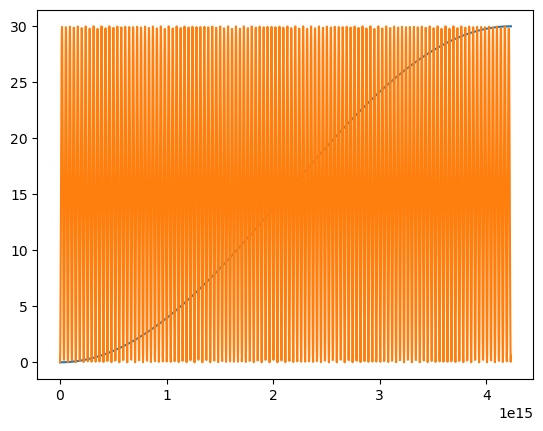

In [60]:
ts = np.linspace(0, theta_max2t, 2000)
plt.plot(ts, h_list2t[-1](ts))
plt.plot(ts, h_list2t[-2](ts))

In [61]:
D_A_val, D_B_val = 0.01, 1.0
N=5000
T=100
delta_t = T/N
model_128_10 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], delta_t=delta_t, Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D)

In [66]:
from turing.three_nodes_circuits import create_circuit_3954

print(df["path"].iloc[run_index])
(params, res, k_max) = load_dataset(df["path"].iloc[run_index])



(_,_,n_val, 
         b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params.values()

kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  

A = res[0, 0, :]
B = res[0, 1, :]
C = res[0, 2, :]      
res_1 = model_128_10.integrate([A,B,C], kinetics, 4*5000, 1)

outputs_second_search/solution_10_3_59.npy


In [67]:
b_C_val, V_C_val,  K_AC_val,  K_BC_val, K_CC_val = 12.38064396,  22.03123576,  26.30818419, 199.99999998, 0.46908522
kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  


res_2 = model_128_10.integrate([A,B,C], kinetics, 4*5000, 1)

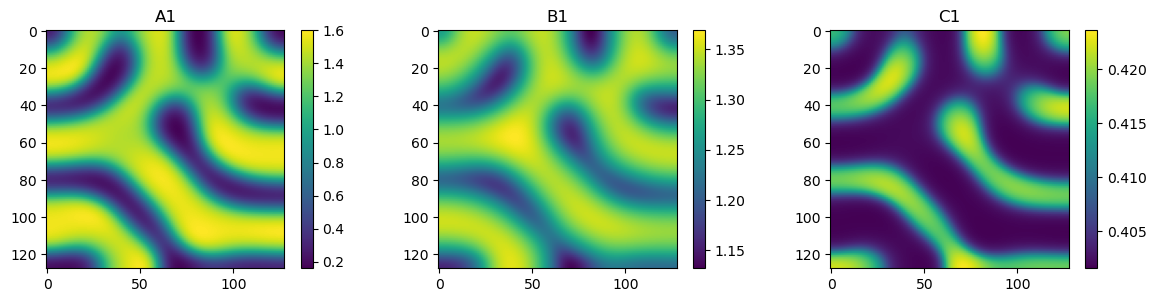

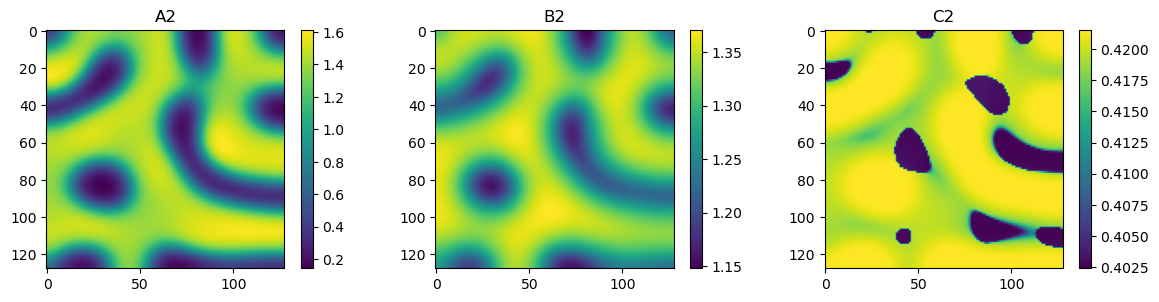

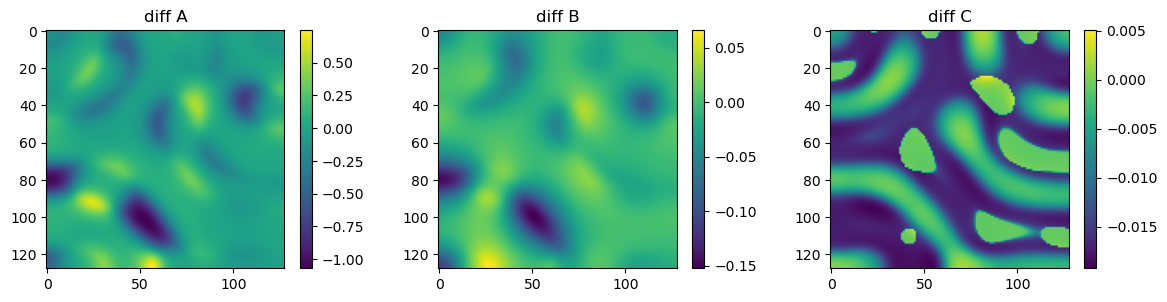

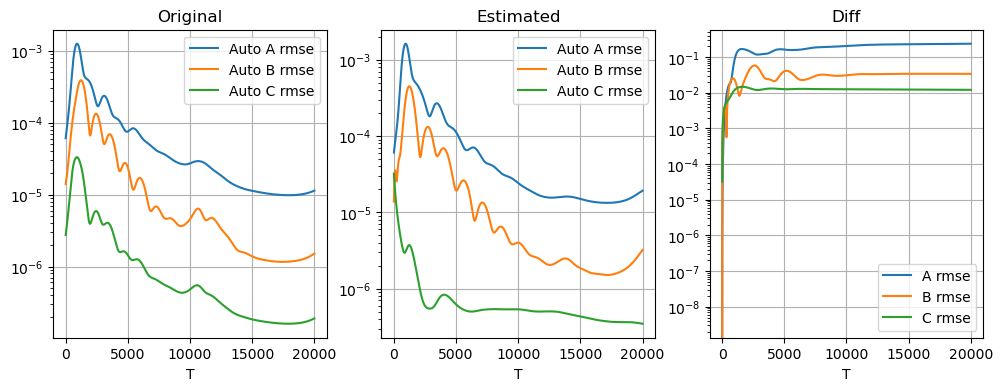

In [68]:
A1 = res_1[-1, 0, :]
B1 = res_1[-1, 1, :]
C1 = res_1[-1, 2, :]
plot_n_im([to(A1), to(B1), to(C1)], 
              ["A1", "B1", "C1"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

A2 = res_2[-1, 0, :]
B2 = res_2[-1, 1, :]
C2 = res_2[-1, 2, :] 
plot_n_im([to(A2), to(B2), to(C2)], 
              ["A2", "B2", "C2"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
              ["diff A", "diff B", "diff C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()
def RMSE(a1, a2):
    return np.sqrt(np.mean((a1-a2)**2, axis=1))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

plt.subplot(132)
plt.plot(RMSE(res_2[1:, 0, :], res_2[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_2[1:, 1, :], res_2[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_2[1:, 2, :], res_2[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

plt.subplot(133)
plt.plot(RMSE(res_1[:, 0, :], res_2[:, 0, :]) , label="A rmse")
plt.plot(RMSE(res_1[:, 1, :], res_2[:, 1, :]) , label="B rmse")
plt.plot(RMSE(res_1[:, 2, :], res_2[:, 2, :]) , label="C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
plt.show()

In [69]:
b_C_val, V_C_val,  K_AC_val,  K_BC_val, K_CC_val = 12.29880276, 21.88051132,  29.82114763, 200.,  0.46593957
kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  


res_3 = model_128_10.integrate([A,B,C], kinetics, 4*5000, 1)

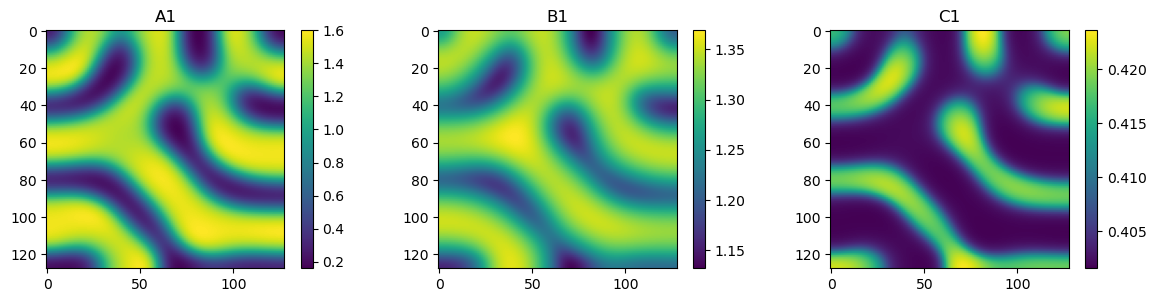

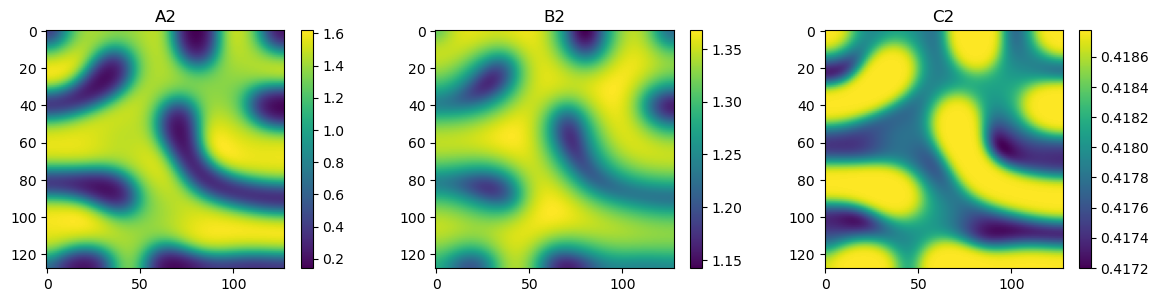

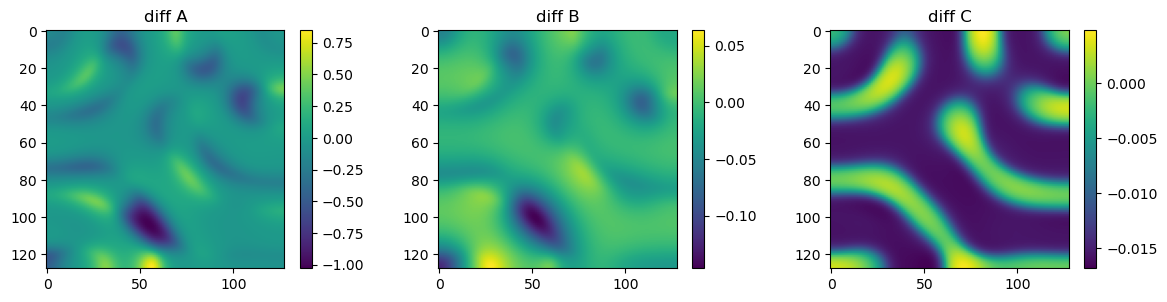

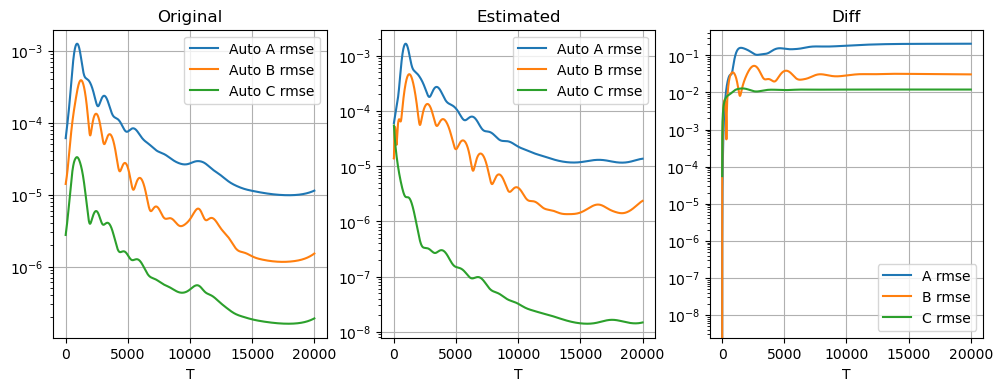

In [70]:
A1 = res_1[-1, 0, :]
B1 = res_1[-1, 1, :]
C1 = res_1[-1, 2, :]
plot_n_im([to(A1), to(B1), to(C1)], 
              ["A1", "B1", "C1"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

A2 = res_3[-1, 0, :]
B2 = res_3[-1, 1, :]
C2 = res_3[-1, 2, :] 
plot_n_im([to(A2), to(B2), to(C2)], 
              ["A2", "B2", "C2"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
              ["diff A", "diff B", "diff C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()
def RMSE(a1, a2):
    return np.sqrt(np.mean((a1-a2)**2, axis=1))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

plt.subplot(132)
plt.plot(RMSE(res_3[1:, 0, :], res_3[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_3[1:, 1, :], res_3[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_3[1:, 2, :], res_3[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

plt.subplot(133)
plt.plot(RMSE(res_1[:, 0, :], res_3[:, 0, :]) , label="A rmse")
plt.plot(RMSE(res_1[:, 1, :], res_3[:, 1, :]) , label="B rmse")
plt.plot(RMSE(res_1[:, 2, :], res_3[:, 2, :]) , label="C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
plt.show()

In [71]:
b_C_val, V_C_val,  K_AC_val,  K_BC_val, K_CC_val = 14.15339395, 31.3124977, 7.33261207, 16.47095347, 0.57742268
kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  


res_4 = model_128_10.integrate([A,B,C], kinetics, 4*5000, 1)

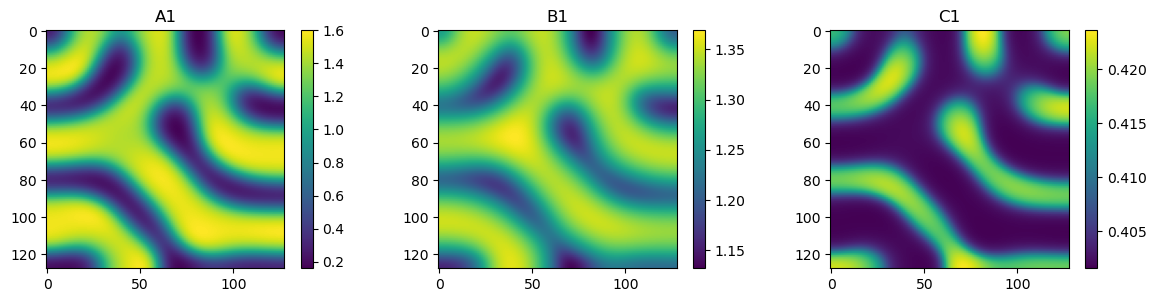

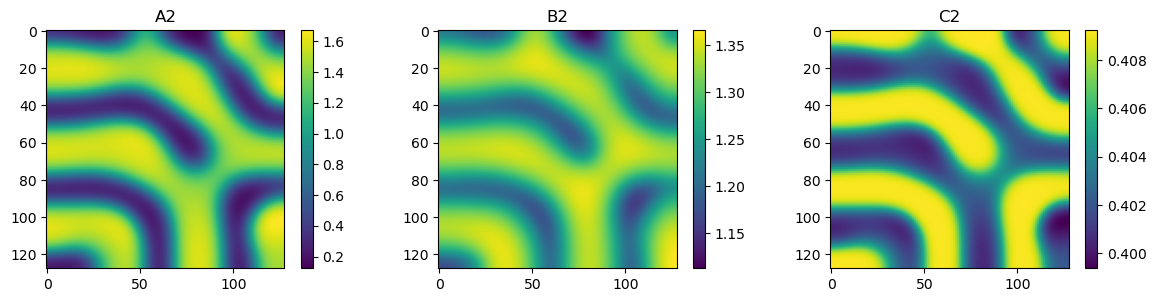

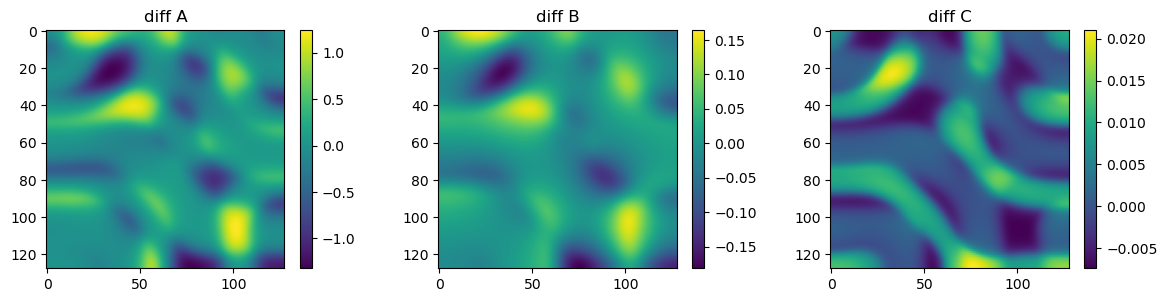

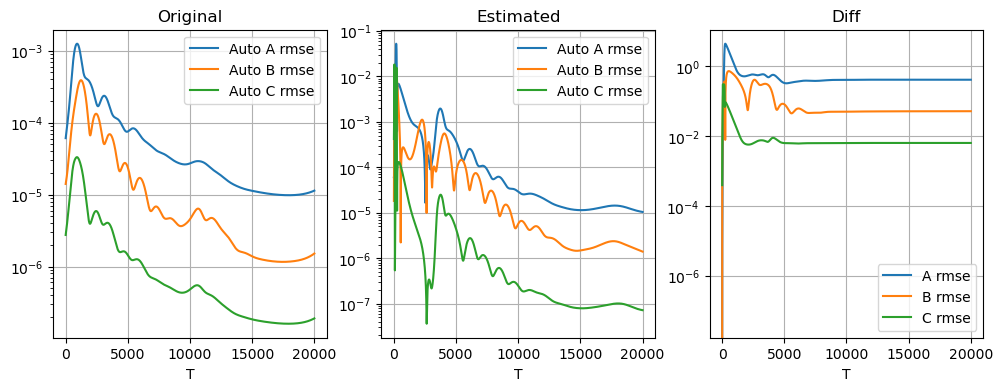

In [72]:
A1 = res_1[-1, 0, :]
B1 = res_1[-1, 1, :]
C1 = res_1[-1, 2, :]
plot_n_im([to(A1), to(B1), to(C1)], 
              ["A1", "B1", "C1"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

A2 = res_4[-1, 0, :]
B2 = res_4[-1, 1, :]
C2 = res_4[-1, 2, :] 
plot_n_im([to(A2), to(B2), to(C2)], 
              ["A2", "B2", "C2"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
              ["diff A", "diff B", "diff C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()
def RMSE(a1, a2):
    return np.sqrt(np.mean((a1-a2)**2, axis=1))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

plt.subplot(132)
plt.plot(RMSE(res_4[1:, 0, :], res_4[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_4[1:, 1, :], res_4[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_4[1:, 2, :], res_4[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

plt.subplot(133)
plt.plot(RMSE(res_1[:, 0, :], res_4[:, 0, :]) , label="A rmse")
plt.plot(RMSE(res_1[:, 1, :], res_4[:, 1, :]) , label="B rmse")
plt.plot(RMSE(res_1[:, 2, :], res_4[:, 2, :]) , label="C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
plt.show()

In [73]:
b_C_val, V_C_val,  K_AC_val,  K_BC_val, K_CC_val = 20.03239203,194.38184146, 0.85155579, 26.56902557,1.58256779
kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  


res_5 = model_128_10.integrate([A,B,C], kinetics, 4*5000, 1)

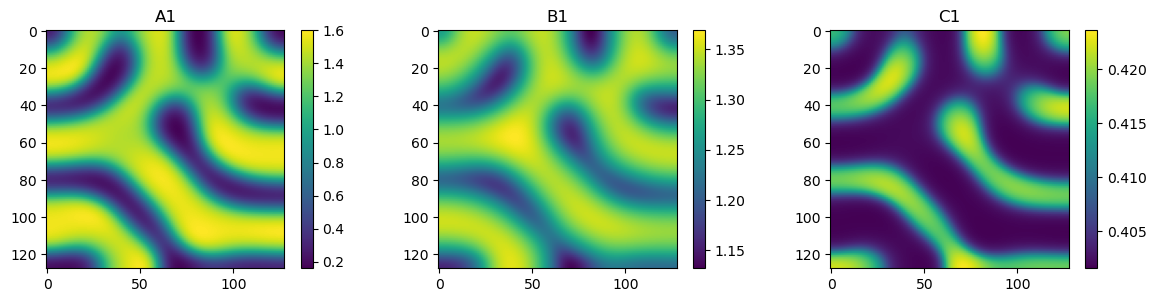

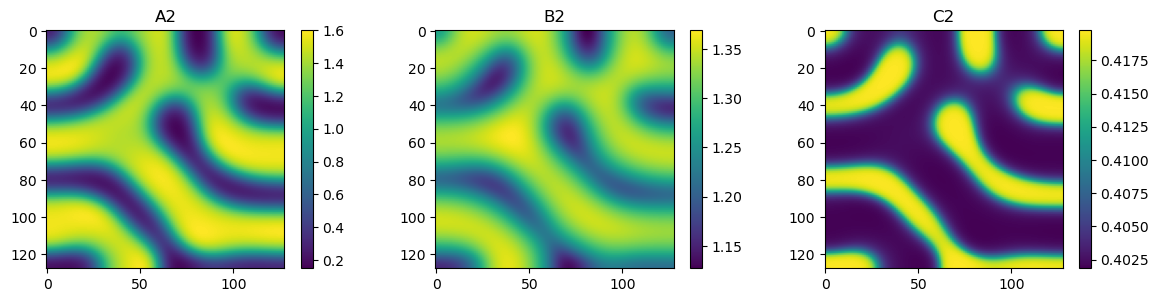

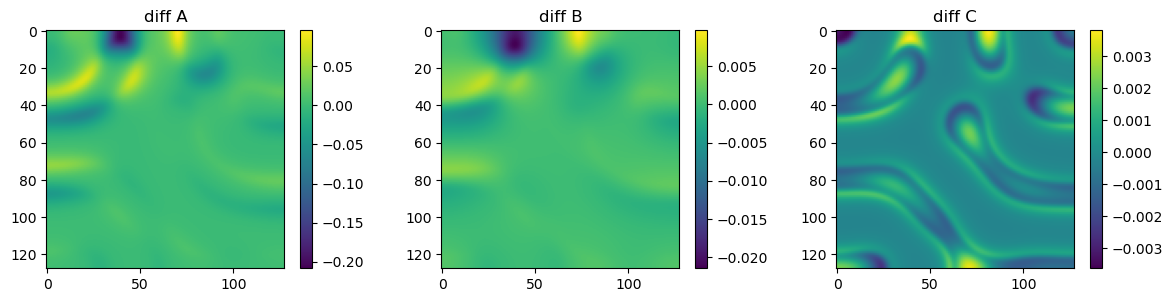

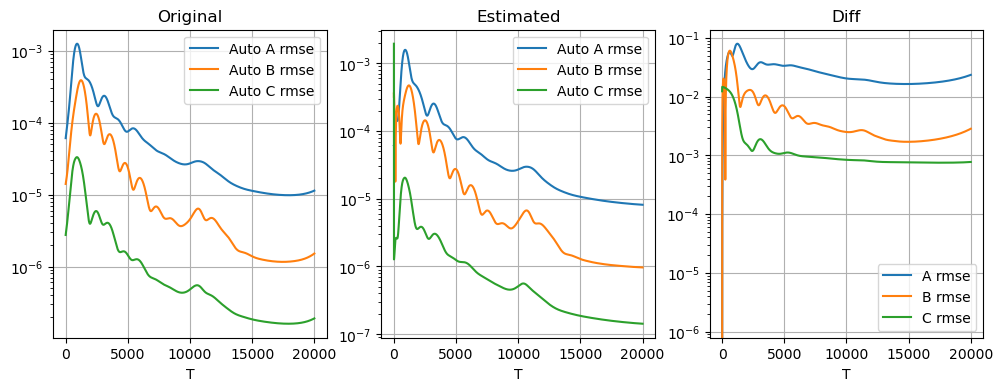

In [74]:
A1 = res_1[-1, 0, :]
B1 = res_1[-1, 1, :]
C1 = res_1[-1, 2, :]
plot_n_im([to(A1), to(B1), to(C1)], 
              ["A1", "B1", "C1"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

A2 = res_5[-1, 0, :]
B2 = res_5[-1, 1, :]
C2 = res_5[-1, 2, :] 
plot_n_im([to(A2), to(B2), to(C2)], 
              ["A2", "B2", "C2"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
              ["diff A", "diff B", "diff C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()
def RMSE(a1, a2):
    return np.sqrt(np.mean((a1-a2)**2, axis=1))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

plt.subplot(132)
plt.plot(RMSE(res_5[1:, 0, :], res_5[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_5[1:, 1, :], res_5[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_5[1:, 2, :], res_5[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

plt.subplot(133)
plt.plot(RMSE(res_1[:, 0, :], res_5[:, 0, :]) , label="A rmse")
plt.plot(RMSE(res_1[:, 1, :], res_5[:, 1, :]) , label="B rmse")
plt.plot(RMSE(res_1[:, 2, :], res_5[:, 2, :]) , label="C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
plt.show()